# **Quantum Simulation** 🧋

# **0 - setup** 🫙


In [1]:
%pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.7 MB/s eta 0:00:00


In [2]:
import torch
import torchsummary
import torch_geometric as pyg
import networkx as nx
import numpy as np
import itertools
import scipy
import wandb
import datetime

from tqdm.auto import tqdm

import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

# **1 - source** ⚗️

## **1.1** - data

I need to generate the graph to input to my model.

(1) Define the appropriate lattice
(2) Define the sublattice one hot encoding
(3) Convert everything to a pyg data structure, edge attr will be 0, node attr will be concat(0,onehot)

### **1.1.1** - square_9

In [3]:
#generate the lattice and equip it with a sublattice encoding (gotta write it custom)
#square N = 9

def square_9(verbose: bool = True):

    #create the lattice
    G = nx.grid_2d_graph(3, 3, periodic=True)

    #initialise the edges and the nodes, add the sublattice encoding
    for edge in G.edges:
        G.edges[edge]["edge_init"] = np.array([0,0,0])

    for nodes in G.nodes:
        G.nodes[nodes]["spin_init"] = 0
        if (nodes[0]+ nodes[1]+2) % 2 == 0:
          G.nodes[nodes]["sublattice_encoding"] = np.array([1,0])
        else:
          G.nodes[nodes]["sublattice_encoding"] = np.array([0,1])

    # convert it to a pytorch geometric compatible graph
    G_pyg = pyg.utils.from_networkx(G, "all", "all")

    if verbose:
        # draw the graph as a sanity check
        plt.figure(figsize=(8, 8))

        color_map = {tuple([0, 1]): "red", tuple([1, 0]): "blue"}
        node_colors = [color_map[tuple(G.nodes[node]["sublattice_encoding"])] for node in G.nodes]

        nx.draw(G, pos = nx.kamada_kawai_layout(G), with_labels=True, node_color=node_colors , node_size=500, font_size=10, edge_color="gray")
        plt.title(f"Lattice Graph")
        plt.show()


        #print the pytorch data as a sanity check
        print(f"G_pyg: {G_pyg}")
        print(f"G_pyg.x: {G_pyg.x}")
        print(f"G_pyg.edge_index: {G_pyg.edge_index}")
        print(f"G_pyg.edge_attr: {G_pyg.edge_attr}")

    return G, G_pyg


### **1.1.2** - square_36

In [4]:
#generate the lattice and equip it with a sublattice encoding (gotta write it custom)
#square N = 36
def square_36(verbose : bool = True):

    # create the lattice
    G = nx.grid_2d_graph(6, 6, periodic=True)


    # initialise node and edges features, equip nodes with the sublattice encoding
    for edge in G.edges:
        G.edges[edge]["edge_init"] = np.array([0,0,0])

    for nodes in G.nodes:
        G.nodes[nodes]["spin_init"] = 0
        if (nodes[0]+ nodes[1]+2) % 2 == 0:
          G.nodes[nodes]["sublattice_encoding"] = np.array([1,0])
        else:
          G.nodes[nodes]["sublattice_encoding"] = np.array([0,1])

    # convert the data to the pytorch geometric format
    G_pyg = pyg.utils.from_networkx(G, "all", "all")

    if verbose:
        # draw the graph as a sanity check
        plt.figure(figsize=(8, 8))

        color_map = {tuple([0, 1]): "red", tuple([1, 0]): "blue"}
        node_colors = [color_map[tuple(G.nodes[node]["sublattice_encoding"])] for node in G.nodes]

        nx.draw(G, pos = nx.kamada_kawai_layout(G), with_labels=True, node_color=node_colors , node_size=500, font_size=10, edge_color="gray")
        plt.title(f"Lattice Graph")
        plt.show()
        #print the pytorch data as a sanity check
        print(G_pyg)
        print(G_pyg.x)
        print(G_pyg.edge_index)

    return G, G_pyg



## **1.2** - model

In this section I need to build the model.

"Next, we use a GNN model with encode-process-decode [4] architecture (Fig 2(b)) to compute a distributed latent representation Y . The encoder maps nodes and edges of input graph X to latent features of width 64. Next, the processor performs M rounds of message passing, updating the graph as Gt = Gt−1 + GNt(Gt−1). The residual GraphNet blocks GNt [41] use MLP node and edge functions. The decoder computes the final latent edge and node features Y from GM , by processing them using a MLP. More details on the architecture can be found in Appendix A 6."

"For all test problems we used the same architecture parameters to accentuate generality of the proposed method. Node and edge functions of the Encoder, Processor and Decoder are implemented as MLPs with 3 hidden layers with ReLU activations. The node and edge embeddings have size 64, while hidden layers width 128. We use 6 message passing steps with residual connections in the Processor. The final linear layer maps 128-dimensional latent vector to 2(1) outputs for GNN(GNN-2) models."

from reference [4]:
A common architecture design is what we call the encode-process-decode con guration (Hamrick
et al. (2018); also see Figure 6ba): an input graph, Ginp is transformed into a latent representation,
G0, by an encoder, GNenc; a shared core block, GNcore, is applied M times to return GM; and
 nally an output graph, Gout, is decoded by GNdec.

#### GN_Encoder

In [5]:
# Edge update model
class EdgeEncoderModel(torch.nn.Module):
    def __init__(self, input_dim, feature_dim):
        super().__init__()
        self.edge_mlp = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 16),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(16, 32),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, feature_dim),
            )

    def forward(self, src, dst, edge_attr, u, batch):
        return self.edge_mlp(edge_attr)

# Node update model
class NodeEncoderModel(torch.nn.Module):
    def __init__(self, input_dim, feature_dim):
        super().__init__()
        self.node_mlp = torch.nn.Sequential(
          torch.nn.Linear(input_dim, 16),
          torch.nn.LeakyReLU(),
          torch.nn.Linear(16, 32),
          torch.nn.LeakyReLU(),
          torch.nn.Linear(32, 64),
          torch.nn.LeakyReLU(),
          torch.nn.Linear(64, feature_dim),
        )

    def forward(self, x, edge_index, edge_attr, u, batch):
        return self.node_mlp(x)



# MetaLayer encoder
class GraphEncoder(torch.nn.Module):
    def __init__(self, input_dim, feature_dim):
        super().__init__()
        self.encoder = pyg.nn.models.MetaLayer(
            EdgeEncoderModel(input_dim, feature_dim),
            NodeEncoderModel(input_dim, feature_dim)
        )

    def forward(self, x, edge_index, edge_attr, u, batch):
        return self.encoder(x, edge_index, edge_attr)


#### GN_Decoder

In [6]:
# Edge update model
class EdgeDecoderModel(torch.nn.Module):
    def __init__(self, feature_dim, hidden_dim):
        super().__init__()
        self.edge_mlp = torch.nn.Sequential(
            torch.nn.Linear(feature_dim, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, feature_dim),
            )

    def forward(self, src, dst, edge_attr, u, batch):
        return self.edge_mlp(edge_attr)

# Node update model
class NodeDecoderModel(torch.nn.Module):
    def __init__(self, feature_dim, hidden_dim):
        super().__init__()
        self.node_mlp = torch.nn.Sequential(
          torch.nn.Linear(feature_dim, hidden_dim),
          torch.nn.LeakyReLU(),
          torch.nn.Linear(hidden_dim, hidden_dim),
          torch.nn.LeakyReLU(),
          torch.nn.Linear(hidden_dim, hidden_dim),
          torch.nn.LeakyReLU(),
          torch.nn.Linear(hidden_dim, feature_dim),
        )

    def forward(self, x, edge_index, edge_attr, u, batch):
        return self.node_mlp(x)



# MetaLayer decoder
class GraphDecoder(torch.nn.Module):
    def __init__(self, feature_dim, hidden_dim):
        super().__init__()
        self.decoder = pyg.nn.models.MetaLayer(
            EdgeDecoderModel(feature_dim, hidden_dim),
            NodeDecoderModel(feature_dim, hidden_dim)
        )

    def forward(self, x, edge_index, edge_attr, u, batch):
        return self.decoder( x, edge_index, edge_attr)

#### GN_Core

In [7]:
# Edge update model
class EdgeCoreModel(torch.nn.Module):
    def __init__(self, feature_dim, hidden_dim):
        super().__init__()
        self.edge_mlp = torch.nn.Sequential(
            torch.nn.Linear(3 * feature_dim, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, feature_dim),
        )

    def forward(self, src, dst, edge_attr, u, batch):
        """
        Forward pass for the edge update model.
        Args:
            src (Tensor): Features of source nodes [E, F_x].
            dst (Tensor): Features of target nodes [E, F_x].
            edge_attr (Tensor): Current edge features [E, F_e].
        Returns:
            Tensor: Updated edge features [E, F_out].
        """
        # Concatenate inputs: src, dst, edge_attr, and global features (mapped to edges)
        edge_inputs = torch.cat([src, dst, edge_attr], dim=1)
        return self.edge_mlp(edge_inputs)

# Node update model
class NodeCoreModel(torch.nn.Module):
    def __init__(self, feature_dimension, hidden_dim):
        super().__init__()
        self.node_mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * feature_dimension, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, feature_dimension),
        )

    def forward(self, x, edge_index, edge_attr, u, batch):
        """
        Forward pass for the node update model.
        Args:
            x (Tensor): Current node features [N, F_x].
            edge_index (Tensor): Graph connectivity [2, E].
            edge_attr (Tensor): Updated edge features [E, F_e].
        Returns:
            Tensor: Updated node features [N, F_out].
        """
        # Aggregate edge features for each node
        row, col = edge_index  # row: source nodes, col: target nodes
        aggregated_edges = pyg.utils.scatter(edge_attr, col, dim=0, reduce="mean", dim_size=x.size(0))

        # Concatenate current node features, aggregated edge features, and global features
        node_inputs = torch.cat([x, aggregated_edges], dim=1)
        return self.node_mlp(node_inputs)



# MetaLayer encoder
class GNCore(torch.nn.Module):
    def __init__(self, feature_dim, hidden_dim):
        super().__init__()
        self.core = pyg.nn.models.MetaLayer(
            EdgeCoreModel(feature_dim, hidden_dim),
            NodeCoreModel(feature_dim, hidden_dim)
        )

    def forward(self, x, edge_index, edge_attr, u, batch):
        _x = x + self.core(x, edge_index, edge_attr)[0], edge_attr + self.core(x, edge_index, edge_attr)[1]
        return  _x

#### Full EPD Model

In [8]:
class FullEPD(torch.nn.Module):
    def __init__(self, input_dim, feature_dim, hidden_dim, num_core_layers):
        super().__init__()

        self.num_core_layers = num_core_layers

        # Encoder
        self.encoder = GraphEncoder(input_dim, feature_dim)

        # Core (stack of GNCore layers)
        self.core = GNCore(feature_dim, hidden_dim)

        # Decoder
        self.decoder = GraphDecoder(feature_dim, hidden_dim)

        #Pooling and Linear
        self.pool = pyg.nn.global_mean_pool
        self.linear = torch.nn.Linear(hidden_dim, 1)

    def forward(self, graph):
        """
        Args:
            x: Input node features [N, F_node].
            edge_index: Graph connectivity [2, E].
            edge_attr: Input edge features [E, F_edge].
        Returns:
            Decoded node and edge features.
        """
        x, edge_index, edge_attr = graph.x, graph.edge_index, graph.edge_attr

        edge_attr = edge_attr.type(torch.float)
        x = x.type(torch.float)

        # Encode node and edge features
        x, edge_attr = self.encoder(x, edge_index, edge_attr, None, None)[0:2]

        # Apply core layers
        for _ in range(self.num_core_layers - 1):
            x, edge_attr = self.core(x, edge_index, edge_attr, None, None)[0:2]

        # Decode the final features
        x, edge_attr = self.decoder(x, edge_index, edge_attr, None, None)[0:2]

        graph = pyg.data.Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

        return graph

#### Full GNN model

In [9]:
# Define a Graph Neural Network Model
class GNN(torch.nn.Module):
    def __init__(self, input_dim, feature_dim, hidden_dim, num_core_layers, activation = None):
        super(GNN, self).__init__()

        # Graph Convolutional Layers
        self.epd_model = FullEPD(input_dim=input_dim, feature_dim=feature_dim, hidden_dim=hidden_dim, num_core_layers=num_core_layers)


        self.final_layer = torch.nn.Linear(feature_dim * 2, 1)

        self.activation = activation


    def forward(self, graph):

        # Pass through the GCN layers
        graph = self.epd_model(graph)

        # Pool node features (global sum pooling)
        node_pooled = torch.sum(graph.edge_attr,dim=0)

        # Pool edge features (sum pooling across edges)
        edge_pooled = torch.sum(graph.x,dim=0)

        # Concatenate node and edge pooled features into a 128-dimensional vector
        combined_features = torch.cat((node_pooled, edge_pooled), dim=-1)

        # Pass through the fully connected layer to get the final estimate
        output = self.final_layer(combined_features)

        if self.activation is not None:
            output = self.activation(output)

        return output

#### Get output utility function

In [10]:
def get_output(x, G_pyg, gnn):
    G_pyg.x[:,0] = x
    return gnn(G_pyg)

## **1.3** - computational basis

In [11]:
def exhaustive(G_pyg):

    '''
    given a pytorch geometric graph, this function will build all its possible spin configurations and return them as a torch tensor
    furthermore, it will return a torch tensor of their one-hot vector representation for quantum stuff
    '''

    all_configurations = torch.zeros((int(2**G_pyg.num_nodes), G_pyg.num_nodes))

    for i, x in enumerate(itertools.product((-1,1), repeat=G_pyg.num_nodes)):
        all_configurations[i,:] = torch.tensor(x)

    return all_configurations

## **1.3**- hamiltonians and quantum utilities

### Classical Hamiltonian
here i will consider a classical Hamiltonian with coupling J and external field M

$H = - \mathbf{b}^T \mathbf{x} - J \mathbf{x}^T \mathbf{A} \mathbf{x}$

In [12]:
def ising_H(x, J:float = 1, M:float = 1, verbose:bool = False):
    "hamiltonian of the ising model, double counting"
    J = 1
    interactions = torch.zeros((G_pyg.num_nodes, G_pyg.num_nodes))
    interactions[G_pyg.edge_index[0], G_pyg.edge_index[1]] = J

    M = 1
    external_field = torch.zeros(G_pyg.num_nodes)

    external_field[:] = M

    x = x.type(torch.float32)
    return - torch.matmul(external_field, x) - torch.matmul(torch.matmul(x.T, interactions), x)




### Quantum  Hamiltonian 🤯

qualitative explanation from intuition built in the 2 spin case:
- $S^z_i S^z_j$: "spin agreement" and conf unchanged
- $S^x_i S^x_j$: "one" and conf with i and j flipped
- $S^y_i S^y_j$: "negative spin agreement" and conf with i and j flipped

My pseudocode:

take a computational basis state c_i, (we are in the row $H_{i,*}$ of the Hamiltonian):

now from c_i compute {c_j} the set of all states coupled with it: for every edge flip its two spins and you have c_j.

compute the diagonal entry H_ii as the Ising energy of c_i (its implicitly a sum over nearest neighbors as SSz does not transform the state)

for c_i and c_j in {c_j}:
    compute H_ij as S^x_iS^x_j + S^y_iS^y_j, namely 1 + negative spin agreement


In [13]:
def cap_H(G_pyg, J: float = 1):

    configurations = exhaustive(G_pyg)
    one_hot_configurations = torch.flip(torch.eye(configurations.shape[0],configurations.shape[0]), dims=[0])

    dimensionality = 2**G_pyg.num_nodes


    H = scipy.sparse.lil_matrix((dimensionality,dimensionality))

    #loop over rows
    for i in range(dimensionality):
        interactions = torch.zeros((G_pyg.num_nodes, G_pyg.num_nodes))
        interactions[G_pyg.edge_index[0], G_pyg.edge_index[1]] = 1

        c_i = configurations[i,:]

        #diagonal
        # * 0.5 because theres double counting above
        H[i,i] = 0.5*J*torch.matmul(torch.matmul(c_i.T, interactions), c_i).item()

        #off diagonal terms
        for edge in range(G_pyg.num_edges):

            c_j = c_i.clone()
            c_j[G_pyg.edge_index[:,edge]] = - c_j[G_pyg.edge_index[:,edge]]

            value = J * (1 - c_j[G_pyg.edge_index[0,edge]] * c_j[G_pyg.edge_index[1,edge]])

            #compute the index
            bin = (c_j + 1) // 2
            j = int(torch.dot(bin.flip(0).to(torch.float), 2**torch.arange(bin.size(0)).to(torch.float)))


            #assign value
            H[i,j] = value.item()


    H = H.tocsc()

    return H

### Overlap between two quantum states

In [14]:
def compute_overlap(state_1, state_2):
    state1_norm = torch.linalg.norm(state_1)
    state2_norm = torch.linalg.norm(state_2)
    return torch.matmul(state_1.conj(), state_2) / (state1_norm  * state2_norm)

## **1.4** - mcmc

In [15]:
#aka g
def random_swap(x):

    x_ = x.clone()

    idx1 = torch.randint(0, len(x_), (1,))

    # opposite_indices = torch.where(x_ == -x_[idx1])[0]

    # idx2 = opposite_indices[torch.randint(0, len(opposite_indices), (1,))].item()

    x_[idx1] =  - x[idx1]
    return x_

In [16]:
def mcmc_step(x, G_pyg, gnn):
    x_ = random_swap(x)

    a_1 = torch.exp(get_output(x_, G_pyg, gnn)).item()
    a_2 = torch.exp(get_output(x, G_pyg, gnn)).item()

    if a_2 == 0:
        acceptance_ratio = 1
    else:
        acceptance_ratio = a_1/a_2

    if torch.rand(1) < acceptance_ratio:
        x = x_

    return x_, x

In [17]:
# MCMC
def mcmc(G_pyg, gnn, burn_in = 1000, n_mc_points = 1000, spacing = 10):

    mc_points = torch.zeros((n_mc_points, G_pyg.num_nodes))


    x = torch.randint(0, 2, (G_pyg.num_nodes,)) * 2 - 1
    x_ = x.clone()

    for i in range(burn_in):
        x = mcmc_step(x, G_pyg, gnn)[1]

    for i in tqdm(range(n_mc_points)):
        for j in range(spacing):
            x = mcmc_step(x, G_pyg, gnn)[1]

        mc_points[i,:] = x


    return mc_points

# **2 - script** 🔥

## **2.1** - root ✅
- classical mixture

- exhaustive

**Data**

/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/convert.py:278: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  data_dict[key] = torch.as_tensor(value)


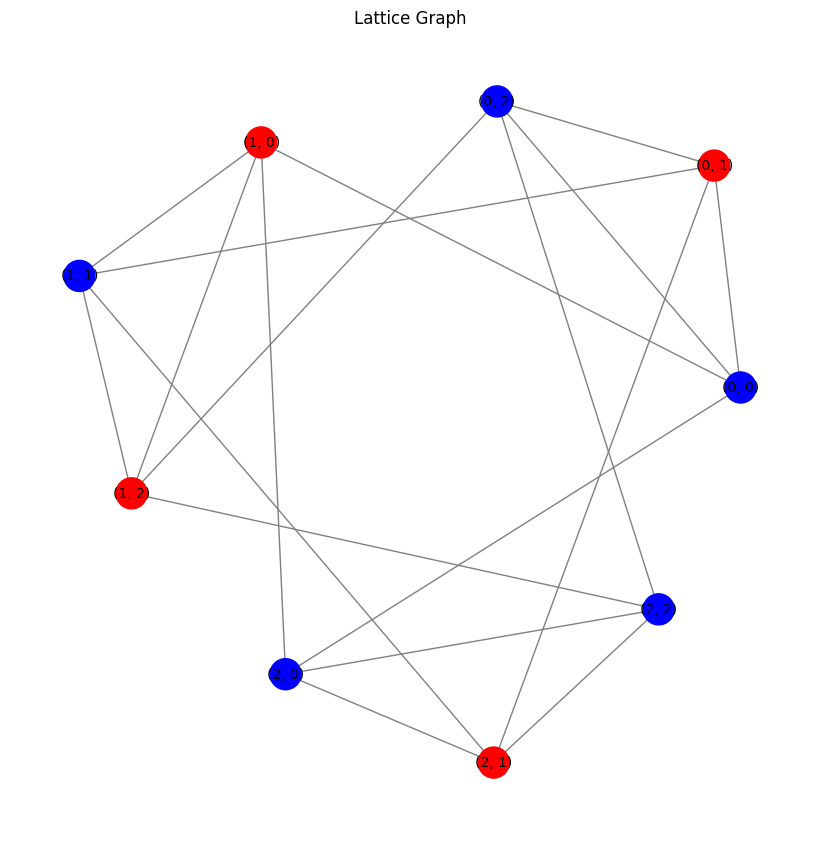

G_pyg: Data(edge_index=[2, 36], x=[9, 3], edge_attr=[36, 3])
G_pyg.x: tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]])
G_pyg.edge_index: tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5,
         6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8],
        [3, 1, 6, 2, 4, 0, 2, 7, 5, 1, 8, 0, 0, 6, 4, 5, 1, 7, 3, 5, 2, 8, 4, 3,
         3, 7, 0, 8, 4, 6, 8, 1, 5, 7, 2, 6]])
G_pyg.edge_attr: tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 

In [18]:
G, G_pyg = square_9()

**Target State**

In [19]:
all_configurations = exhaustive(G_pyg)

lowest_energy = 100

for i in range(all_configurations.shape[0]):

    current_energy = ising_H(all_configurations[i,:]) #+ 45

    if current_energy < lowest_energy:
        lowest_energy = current_energy
        lowest_energy_state = all_configurations[i,:]



<ipython-input-12-41e522ea775a>:13: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  return - torch.matmul(external_field, x) - torch.matmul(torch.matmul(x.T, interactions), x)


In [20]:
print(f"lowest energy: {lowest_energy:.2f}")
print("lowest energy state: ", lowest_energy_state)

lowest energy: -45.00
lowest energy state:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.])


**Model**

In [21]:
gnn = GNN(input_dim=3, feature_dim=64, hidden_dim=128, num_core_layers=6)
optimizer = torch.optim.Adam(gnn.parameters(), lr=0.001, weight_decay=1e-5)

torch.set_printoptions(profile="full")

**Optimisation**

In [22]:
wandb.finish()

In [23]:
#Training Loop
num_epochs = 2000
all_configurations = exhaustive(G_pyg)

wandb.login()
wandb.init(project="quantum-simulation-fp", name = f"root_{datetime.datetime.now().strftime('%Y-%m-%d-%H:%M')}")

for epoch in tqdm(range(num_epochs)):

    optimizer.zero_grad()

    energy_distribution = torch.zeros((all_configurations.shape[0], 2))

    for i in range(all_configurations.shape[0]):
        energy_distribution[i,0] = torch.exp(get_output(all_configurations[i,:], G_pyg, gnn))
        energy_distribution[i,1] = ising_H(all_configurations[i,:]) #+ 45

    norm_energy_distribution = energy_distribution[:,0] / torch.sum(energy_distribution[:,0])

    regularisation = torch.log(torch.mean(energy_distribution[:,0]))**2 #nice shape in geogebra

    # Compute loss, use regularisation to prevent the estimates from becoming too big/small
    loss = torch.matmul(norm_energy_distribution.T, energy_distribution[:,1]) + 0.0001 * regularisation

    # Backpropagation
    loss.backward()

    torch.nn.utils.clip_grad_norm_(gnn.parameters(), max_norm=1.0)

    # Update weights
    optimizer.step()


    print(energy_distribution[:,0])

    with torch.no_grad():
        excess_energy = torch.matmul(norm_energy_distribution.T, energy_distribution[:,1]) - lowest_energy

        wandb.log({"excess_energy": excess_energy})

        if excess_energy < 0.0001:
            wandb.finish()
            print("success!!!")
            break


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dan_mon_uni (dan_mon_uni-uni). Use `wandb login --relogin` to force relogin


  0%|          | 0/2000 [00:00<?, ?it/s]

tensor([2.0196, 2.0198, 2.0211, 2.0213, 2.0198, 2.0200, 2.0213, 2.0216, 2.0211,
        2.0213, 2.0226, 2.0229, 2.0213, 2.0216, 2.0229, 2.0231, 2.0198, 2.0200,
        2.0214, 2.0216, 2.0200, 2.0203, 2.0216, 2.0218, 2.0214, 2.0216, 2.0229,
        2.0231, 2.0216, 2.0218, 2.0231, 2.0234, 2.0211, 2.0213, 2.0226, 2.0229,
        2.0213, 2.0216, 2.0229, 2.0231, 2.0226, 2.0228, 2.0241, 2.0244, 2.0228,
        2.0231, 2.0244, 2.0246, 2.0214, 2.0216, 2.0229, 2.0231, 2.0216, 2.0218,
        2.0231, 2.0234, 2.0229, 2.0231, 2.0244, 2.0246, 2.0231, 2.0233, 2.0246,
        2.0249, 2.0198, 2.0200, 2.0213, 2.0216, 2.0200, 2.0203, 2.0216, 2.0218,
        2.0213, 2.0216, 2.0229, 2.0231, 2.0216, 2.0218, 2.0231, 2.0234, 2.0200,
        2.0203, 2.0216, 2.0218, 2.0202, 2.0205, 2.0218, 2.0221, 2.0216, 2.0218,
        2.0231, 2.0234, 2.0218, 2.0221, 2.0233, 2.0236, 2.0213, 2.0216, 2.0228,
        2.0231, 2.0216, 2.0218, 2.0231, 2.0233, 2.0228, 2.0231, 2.0243, 2.0246,
        2.0231, 2.0233, 2.0246, 2.0249, 

excess_energy,████████▇▆▄▂▁▁▁▁
excess_energy,-0.0


success!!!


## **2.2** - branch_mcmc ✅
- classical mixture
- mcmc

**Data**

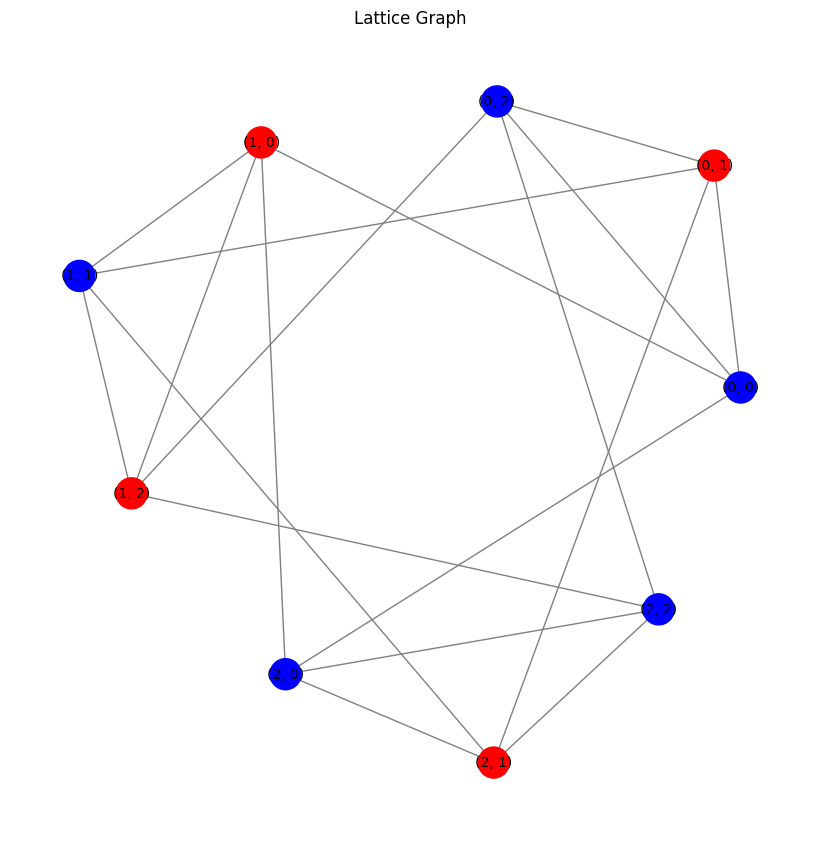

G_pyg: Data(edge_index=[2, 36], x=[9, 3], edge_attr=[36, 3])
G_pyg.x: tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]])
G_pyg.edge_index: tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5,
         6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8],
        [3, 1, 6, 2, 4, 0, 2, 7, 5, 1, 8, 0, 0, 6, 4, 5, 1, 7, 3, 5, 2, 8, 4, 3,
         3, 7, 0, 8, 4, 6, 8, 1, 5, 7, 2, 6]])
G_pyg.edge_attr: tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 

In [ ]:
G, G_pyg = square_9()

**Target State**

In [ ]:
all_configurations = exhaustive(G_pyg)

lowest_energy = 100

for i in range(all_configurations.shape[0]):

    current_energy = ising_H(all_configurations[i,:]) #+ 45

    if current_energy < lowest_energy:
        lowest_energy = current_energy
        lowest_energy_state = all_configurations[i,:]



In [ ]:
print(f"lowest energy: {lowest_energy:.2f}")
print("lowest energy state: ", lowest_energy_state)

lowest energy: -45.00
lowest energy state:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.])


**Model**

In [ ]:
gnn = GNN(input_dim=3, feature_dim=64, hidden_dim=128, num_core_layers=6)
optimizer = torch.optim.Adam(gnn.parameters(), lr=0.001, weight_decay=1e-5)

torch.set_printoptions(profile="full")

**Optimisation**

In [ ]:
wandb.finish()

In [ ]:
#Training Loop
num_epochs = 2000
all_configurations = exhaustive(G_pyg)

wandb.login()
wandb.init(project="quantum-simulation-fp", name = f"branch_mcmc_{datetime.datetime.now().strftime('%Y-%m-%d-%H:%M')}")

for epoch in tqdm(range(num_epochs)):

    with torch.no_grad():
        # forward pass
        sampled_points = mcmc(G_pyg, gnn, burn_in = 1000, n_mc_points = int(1000*0.95**epoch), spacing = 10)

    gnn.train()
    optimizer.zero_grad()

    est_energy_distribution = torch.zeros((sampled_points.shape[0], 2))

    for i in range(sampled_points.shape[0]):
        est_energy_distribution[i,0] = torch.exp(get_output(sampled_points[i,:], G_pyg, gnn)) + 0.00000001
        est_energy_distribution[i,1] = ising_H(sampled_points[i,:]) #+ 45

    norm_est_energy_distribution = est_energy_distribution[:,0] / torch.sum(est_energy_distribution[:,0])

    regularisation_term = torch.log(torch.mean(est_energy_distribution[:,0]))**2 #nice shape in geogebra

    # compute loss
    loss = torch.matmul(norm_est_energy_distribution.T, est_energy_distribution[:,1]) + 0.0001 * regularisation_term

    # backpropagation
    loss.backward()

    # update weights
    optimizer.step()

    #log status
    with torch.no_grad():

        energy_distribution = torch.zeros((all_configurations.shape[0], 2))
        for i in range(all_configurations.shape[0]):
            energy_distribution[i,0] = torch.exp(get_output(all_configurations[i,:], G_pyg, gnn)) + 0.00000001
            energy_distribution[i,1] = ising_H(all_configurations[i,:]) #+ 45

        norm_energy_distribution = energy_distribution[:,0] / torch.sum(energy_distribution[:,0])

        print(energy_distribution[:,0])

        excess_energy = torch.matmul(norm_energy_distribution.T, energy_distribution[:,1]).item() - lowest_energy

        wandb.log({"excess_energy": excess_energy})

        if excess_energy < 0.0001:
            wandb.finish()
            print("success!!!")
            break

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

tensor([0.6114, 0.6140, 0.6142, 0.6168, 0.6140, 0.6166, 0.6168, 0.6194, 0.6142,
        0.6168, 0.6170, 0.6196, 0.6168, 0.6194, 0.6196, 0.6223, 0.6140, 0.6166,
        0.6168, 0.6194, 0.6166, 0.6191, 0.6194, 0.6220, 0.6168, 0.6194, 0.6196,
        0.6223, 0.6194, 0.6220, 0.6222, 0.6249, 0.6142, 0.6168, 0.6170, 0.6196,
        0.6168, 0.6194, 0.6196, 0.6223, 0.6170, 0.6196, 0.6199, 0.6225, 0.6196,
        0.6222, 0.6225, 0.6251, 0.6168, 0.6194, 0.6196, 0.6222, 0.6194, 0.6220,
        0.6223, 0.6249, 0.6196, 0.6222, 0.6225, 0.6251, 0.6222, 0.6248, 0.6251,
        0.6277, 0.6140, 0.6166, 0.6168, 0.6194, 0.6166, 0.6192, 0.6194, 0.6220,
        0.6168, 0.6194, 0.6196, 0.6223, 0.6194, 0.6220, 0.6222, 0.6249, 0.6166,
        0.6191, 0.6194, 0.6220, 0.6191, 0.6217, 0.6220, 0.6246, 0.6194, 0.6220,
        0.6222, 0.6249, 0.6220, 0.6246, 0.6249, 0.6275, 0.6168, 0.6194, 0.6196,
        0.6222, 0.6194, 0.6220, 0.6222, 0.6249, 0.6196, 0.6222, 0.6225, 0.6251,
        0.6222, 0.6248, 0.6251, 0.6277, 

  0%|          | 0/950 [00:00<?, ?it/s]

tensor([0.6985, 0.7047, 0.7056, 0.7120, 0.7047, 0.7111, 0.7120, 0.7185, 0.7056,
        0.7120, 0.7128, 0.7193, 0.7119, 0.7184, 0.7192, 0.7258, 0.7047, 0.7109,
        0.7119, 0.7183, 0.7109, 0.7173, 0.7183, 0.7249, 0.7119, 0.7183, 0.7193,
        0.7258, 0.7183, 0.7248, 0.7257, 0.7324, 0.7056, 0.7119, 0.7128, 0.7192,
        0.7120, 0.7184, 0.7193, 0.7258, 0.7128, 0.7193, 0.7201, 0.7267, 0.7193,
        0.7258, 0.7267, 0.7334, 0.7119, 0.7183, 0.7193, 0.7257, 0.7183, 0.7248,
        0.7258, 0.7324, 0.7193, 0.7258, 0.7267, 0.7334, 0.7258, 0.7324, 0.7334,
        0.7401, 0.7047, 0.7111, 0.7119, 0.7184, 0.7110, 0.7174, 0.7183, 0.7249,
        0.7120, 0.7185, 0.7192, 0.7258, 0.7183, 0.7249, 0.7257, 0.7324, 0.7109,
        0.7173, 0.7183, 0.7248, 0.7173, 0.7238, 0.7247, 0.7314, 0.7183, 0.7249,
        0.7257, 0.7324, 0.7247, 0.7314, 0.7323, 0.7391, 0.7119, 0.7183, 0.7191,
        0.7257, 0.7183, 0.7248, 0.7257, 0.7324, 0.7193, 0.7258, 0.7266, 0.7333,
        0.7257, 0.7324, 0.7332, 0.7400, 

  0%|          | 0/902 [00:00<?, ?it/s]

tensor([0.8699, 0.8857, 0.8882, 0.9046, 0.8857, 0.9019, 0.9046, 0.9212, 0.8882,
        0.9046, 0.9070, 0.9238, 0.9044, 0.9211, 0.9237, 0.9408, 0.8856, 0.9017,
        0.9044, 0.9210, 0.9017, 0.9181, 0.9210, 0.9380, 0.9044, 0.9210, 0.9236,
        0.9408, 0.9209, 0.9378, 0.9406, 0.9581, 0.8882, 0.9044, 0.9070, 0.9237,
        0.9046, 0.9211, 0.9238, 0.9408, 0.9072, 0.9239, 0.9263, 0.9435, 0.9239,
        0.9408, 0.9435, 0.9610, 0.9044, 0.9209, 0.9236, 0.9406, 0.9210, 0.9378,
        0.9408, 0.9581, 0.9238, 0.9408, 0.9435, 0.9610, 0.9408, 0.9581, 0.9610,
        0.9789, 0.8857, 0.9019, 0.9044, 0.9211, 0.9019, 0.9183, 0.9211, 0.9380,
        0.9046, 0.9212, 0.9237, 0.9408, 0.9211, 0.9380, 0.9407, 0.9581, 0.9017,
        0.9181, 0.9209, 0.9378, 0.9181, 0.9348, 0.9378, 0.9551, 0.9210, 0.9380,
        0.9406, 0.9581, 0.9378, 0.9551, 0.9580, 0.9757, 0.9044, 0.9209, 0.9235,
        0.9405, 0.9211, 0.9378, 0.9407, 0.9579, 0.9239, 0.9408, 0.9434, 0.9609,
        0.9409, 0.9581, 0.9609, 0.9787, 

  0%|          | 0/857 [00:00<?, ?it/s]

tensor([0.9134, 0.9457, 0.9508, 0.9849, 0.9457, 0.9794, 0.9849, 1.0205, 0.9508,
        0.9849, 0.9897, 1.0257, 0.9844, 1.0200, 1.0252, 1.0628, 0.9454, 0.9788,
        0.9846, 1.0199, 0.9788, 1.0137, 1.0199, 1.0568, 0.9846, 1.0199, 1.0254,
        1.0627, 1.0194, 1.0563, 1.0621, 1.1011, 0.9508, 0.9844, 0.9897, 1.0252,
        0.9849, 1.0200, 1.0257, 1.0628, 0.9904, 1.0259, 1.0309, 1.0684, 1.0259,
        1.0630, 1.0684, 1.1076, 0.9846, 1.0194, 1.0254, 1.0621, 1.0199, 1.0563,
        1.0627, 1.1011, 1.0260, 1.0628, 1.0686, 1.1074, 1.0628, 1.1013, 1.1074,
        1.1481, 0.9457, 0.9794, 0.9844, 1.0200, 0.9791, 1.0144, 1.0197, 1.0570,
        0.9849, 1.0205, 1.0252, 1.0628, 1.0197, 1.0570, 1.0620, 1.1013, 0.9788,
        1.0137, 1.0194, 1.0563, 1.0134, 1.0499, 1.0559, 1.0945, 1.0199, 1.0568,
        1.0621, 1.1011, 1.0559, 1.0945, 1.1002, 1.1410, 0.9844, 1.0196, 1.0247,
        1.0618, 1.0197, 1.0565, 1.0620, 1.1008, 1.0259, 1.0630, 1.0679, 1.1071,
        1.0627, 1.1015, 1.1067, 1.1477, 

  0%|          | 0/814 [00:00<?, ?it/s]

tensor([0.9558, 1.0246, 1.0351, 1.1105, 1.0246, 1.0988, 1.1105, 1.1920, 1.0351,
        1.1105, 1.1209, 1.2037, 1.1096, 1.1909, 1.2027, 1.2919, 1.0235, 1.0973,
        1.1094, 1.1903, 1.0973, 1.1767, 1.1903, 1.2776, 1.1094, 1.1903, 1.2025,
        1.2912, 1.1893, 1.2765, 1.2901, 1.3859, 1.0351, 1.1096, 1.1209, 1.2027,
        1.1105, 1.1909, 1.2037, 1.2919, 1.1225, 1.2043, 1.2156, 1.3053, 1.2043,
        1.2926, 1.3053, 1.4022, 1.1094, 1.1893, 1.2025, 1.2901, 1.1903, 1.2765,
        1.2912, 1.3859, 1.2041, 1.2919, 1.3051, 1.4015, 1.2919, 1.3867, 1.4015,
        1.5055, 1.0246, 1.0988, 1.1096, 1.1909, 1.0984, 1.1783, 1.1905, 1.2783,
        1.1105, 1.1920, 1.2027, 1.2919, 1.1905, 1.2783, 1.2904, 1.3867, 1.0972,
        1.1767, 1.1893, 1.2765, 1.1763, 1.2619, 1.2760, 1.3701, 1.1903, 1.2776,
        1.2901, 1.3859, 1.2760, 1.3701, 1.3842, 1.4875, 1.1096, 1.1899, 1.2016,
        1.2897, 1.1905, 1.2772, 1.2904, 1.3855, 1.2043, 1.2926, 1.3042, 1.4011,
        1.2922, 1.3874, 1.4005, 1.5051, 

  0%|          | 0/773 [00:00<?, ?it/s]

tensor([0.7239, 0.8141, 0.8294, 0.9374, 0.8141, 0.9194, 0.9374, 1.0641, 0.8294,
        0.9374, 0.9502, 1.0795, 0.9327, 1.0587, 1.0740, 1.2253, 0.8125, 0.9137,
        0.9356, 1.0575, 0.9137, 1.0320, 1.0575, 1.2004, 0.9356, 1.0575, 1.0773,
        1.2239, 1.0522, 1.1944, 1.2177, 1.3893, 0.8294, 0.9327, 0.9502, 1.0740,
        0.9374, 1.0587, 1.0795, 1.2253, 0.9557, 1.0803, 1.0950, 1.2439, 1.0803,
        1.2263, 1.2439, 1.4192, 0.9356, 1.0522, 1.0773, 1.2177, 1.0575, 1.1944,
        1.2239, 1.3893, 1.0836, 1.2248, 1.2478, 1.4176, 1.2248, 1.3904, 1.4176,
        1.6173, 0.8141, 0.9194, 0.9327, 1.0587, 0.9155, 1.0384, 1.0542, 1.2018,
        0.9374, 1.0641, 1.0740, 1.2253, 1.0542, 1.2018, 1.2139, 1.3909, 0.9137,
        1.0320, 1.0522, 1.1944, 1.0276, 1.1655, 1.1893, 1.3558, 1.0575, 1.2004,
        1.2177, 1.3893, 1.1893, 1.3558, 1.3764, 1.5771, 0.9327, 1.0534, 1.0686,
        1.2130, 1.0542, 1.1957, 1.2139, 1.3839, 1.0803, 1.2263, 1.2377, 1.4121,
        1.2210, 1.3920, 1.4060, 1.6110, 

  0%|          | 0/735 [00:00<?, ?it/s]

tensor([0.5575, 0.7054, 0.7314, 0.9213, 0.7054, 0.8869, 0.9213, 1.1532, 0.7314,
        0.9213, 0.9596, 1.2034, 0.9255, 1.1584, 1.2088, 1.5062, 0.7027, 0.8891,
        0.9178, 1.1562, 0.8891, 1.1180, 1.1562, 1.4472, 0.9178, 1.1562, 1.1988,
        1.5034, 1.1614, 1.4538, 1.5102, 1.8817, 0.7314, 0.9255, 0.9596, 1.2088,
        0.9213, 1.1584, 1.2034, 1.5062, 0.9577, 1.2064, 1.2565, 1.5758, 1.2064,
        1.5101, 1.5758, 1.9634, 0.9178, 1.1614, 1.1988, 1.5102, 1.1562, 1.4538,
        1.5034, 1.8817, 1.1964, 1.5071, 1.5627, 1.9596, 1.5071, 1.8864, 1.9596,
        2.4415, 0.7054, 0.8869, 0.9255, 1.1584, 0.8925, 1.1152, 1.1658, 1.4500,
        0.9213, 1.1532, 1.2088, 1.5062, 1.1658, 1.4500, 1.5228, 1.8852, 0.8891,
        1.1180, 1.1614, 1.4538, 1.1251, 1.4057, 1.4630, 1.8196, 1.1562, 1.4472,
        1.5102, 1.8817, 1.4630, 1.8196, 1.9025, 2.3551, 0.9255, 1.1636, 1.2142,
        1.5199, 1.1658, 1.4566, 1.5227, 1.8938, 1.2064, 1.5100, 1.5829, 1.9723,
        1.5198, 1.8901, 1.9851, 2.4574, 

  0%|          | 0/698 [00:00<?, ?it/s]

tensor([0.1113, 0.1459, 0.1524, 0.2080, 0.1459, 0.1981, 0.2080, 0.2938, 0.1524,
        0.2080, 0.2088, 0.2965, 0.1999, 0.2824, 0.2850, 0.4188, 0.1442, 0.1892,
        0.2056, 0.2806, 0.1892, 0.2569, 0.2806, 0.3964, 0.2056, 0.2806, 0.2931,
        0.4162, 0.2697, 0.3810, 0.4000, 0.5880, 0.1524, 0.1999, 0.2088, 0.2850,
        0.2080, 0.2824, 0.2965, 0.4188, 0.2182, 0.2979, 0.2990, 0.4246, 0.2979,
        0.4208, 0.4246, 0.6241, 0.2056, 0.2697, 0.2931, 0.4000, 0.2806, 0.3810,
        0.4162, 0.5880, 0.3063, 0.4181, 0.4367, 0.6202, 0.4181, 0.5907, 0.6202,
        0.9116, 0.1459, 0.1981, 0.1999, 0.2824, 0.1914, 0.2690, 0.2729, 0.3989,
        0.2080, 0.2938, 0.2850, 0.4188, 0.2729, 0.3989, 0.3890, 0.5917, 0.1892,
        0.2569, 0.2697, 0.3810, 0.2482, 0.3488, 0.3681, 0.5382, 0.2806, 0.3964,
        0.4000, 0.5880, 0.3681, 0.5382, 0.5461, 0.8307, 0.1999, 0.2714, 0.2739,
        0.3869, 0.2729, 0.3834, 0.3890, 0.5687, 0.2979, 0.4208, 0.4081, 0.5999,
        0.4066, 0.5945, 0.5797, 0.8818, 

  0%|          | 0/663 [00:00<?, ?it/s]

tensor([0.0257, 0.0396, 0.0423, 0.0710, 0.0396, 0.0656, 0.0710, 0.1279, 0.0423,
        0.0710, 0.0697, 0.1274, 0.0652, 0.1176, 0.1170, 0.2294, 0.0385, 0.0594,
        0.0691, 0.1158, 0.0594, 0.0982, 0.1158, 0.2087, 0.0691, 0.1158, 0.1238,
        0.2261, 0.1064, 0.1918, 0.2078, 0.4074, 0.0423, 0.0652, 0.0697, 0.1170,
        0.0710, 0.1176, 0.1274, 0.2294, 0.0769, 0.1291, 0.1268, 0.2316, 0.1291,
        0.2326, 0.2316, 0.4542, 0.0691, 0.1064, 0.1238, 0.2078, 0.1158, 0.1918,
        0.2261, 0.4074, 0.1366, 0.2292, 0.2450, 0.4475, 0.2292, 0.4131, 0.4475,
        0.8777, 0.0396, 0.0656, 0.0652, 0.1176, 0.0611, 0.1085, 0.1095, 0.2118,
        0.0710, 0.1279, 0.1170, 0.2294, 0.1095, 0.2118, 0.1964, 0.4134, 0.0594,
        0.0982, 0.1064, 0.1918, 0.0915, 0.1627, 0.1786, 0.3455, 0.1158, 0.2087,
        0.2078, 0.4074, 0.1786, 0.3455, 0.3488, 0.7342, 0.0652, 0.1080, 0.1075,
        0.1937, 0.1095, 0.1946, 0.1964, 0.3800, 0.1291, 0.2326, 0.2128, 0.4174,
        0.2167, 0.4192, 0.3890, 0.8187, 

  0%|          | 0/630 [00:00<?, ?it/s]

tensor([5.8731e-03, 1.4247e-02, 1.6147e-02, 4.2037e-02, 1.4247e-02, 3.5538e-02,
        4.2037e-02, 1.1163e-01, 1.6147e-02, 4.2037e-02, 4.4516e-02, 1.2399e-01,
        3.9265e-02, 1.0482e-01, 1.1618e-01, 3.2921e-01, 1.3072e-02, 3.1780e-02,
        3.8588e-02, 1.0045e-01, 3.1780e-02, 7.9448e-02, 1.0045e-01, 2.6674e-01,
        3.8588e-02, 1.0045e-01, 1.1388e-01, 3.1637e-01, 9.4040e-02, 2.5099e-01,
        2.9715e-01, 8.4002e-01, 1.6147e-02, 3.9265e-02, 4.4516e-02, 1.1618e-01,
        4.2037e-02, 1.0482e-01, 1.2399e-01, 3.2921e-01, 4.9716e-02, 1.2941e-01,
        1.3745e-01, 3.8280e-01, 1.2941e-01, 3.4442e-01, 3.8280e-01, 1.0818e+00,
        3.8588e-02, 9.4040e-02, 1.1388e-01, 2.9715e-01, 1.0045e-01, 2.5099e-01,
        3.1637e-01, 8.4002e-01, 1.2653e-01, 3.2937e-01, 3.7336e-01, 1.0374e+00,
        3.2937e-01, 8.7661e-01, 1.0374e+00, 2.9254e+00, 1.4247e-02, 3.5538e-02,
        3.9265e-02, 1.0482e-01, 3.4636e-02, 8.8613e-02, 1.0246e-01, 2.7831e-01,
        4.2037e-02, 1.1163e-01, 1.1618e-

  0%|          | 0/598 [00:00<?, ?it/s]

tensor([1.5611e-04, 3.0841e-04, 3.4004e-04, 9.6737e-04, 3.0841e-04, 8.5712e-04,
        9.6737e-04, 3.8744e-03, 3.4004e-04, 9.6737e-04, 7.4202e-04, 3.0428e-03,
        6.7261e-04, 2.6929e-03, 2.1139e-03, 1.2198e-02, 2.9448e-04, 5.8215e-04,
        9.2213e-04, 2.6255e-03, 5.8215e-04, 1.6191e-03, 2.6255e-03, 1.0523e-02,
        9.2213e-04, 2.6255e-03, 2.8960e-03, 1.1885e-02, 1.8254e-03, 7.3150e-03,
        8.2577e-03, 4.7679e-02, 3.4004e-04, 6.7261e-04, 7.4202e-04, 2.1139e-03,
        9.6737e-04, 2.6929e-03, 3.0428e-03, 1.2198e-02, 1.0901e-03, 3.1068e-03,
        2.3836e-03, 9.7930e-03, 3.1068e-03, 1.2463e-02, 9.7930e-03, 5.6578e-02,
        9.2213e-04, 1.8254e-03, 2.8960e-03, 8.2577e-03, 2.6255e-03, 7.3150e-03,
        1.1885e-02, 4.7679e-02, 4.2582e-03, 1.2145e-02, 1.3403e-02, 5.5102e-02,
        1.2145e-02, 4.8758e-02, 5.5102e-02, 3.1852e-01, 3.0841e-04, 8.5712e-04,
        6.7261e-04, 2.6929e-03, 6.1029e-04, 2.3860e-03, 1.9170e-03, 1.0796e-02,
        9.6737e-04, 3.8744e-03, 2.1139e-

  0%|          | 0/568 [00:00<?, ?it/s]

tensor([1.8269e-06, 3.9111e-06, 4.3046e-06, 1.4935e-05, 3.9111e-06, 1.3413e-05,
        1.4935e-05, 8.6174e-05, 4.3046e-06, 1.4935e-05, 1.0173e-05, 5.7972e-05,
        9.2386e-06, 5.2002e-05, 3.5358e-05, 3.3867e-04, 3.7825e-06, 8.1140e-06,
        1.4409e-05, 5.0664e-05, 8.1140e-06, 2.7867e-05, 5.0664e-05, 2.9564e-04,
        1.4409e-05, 5.0664e-05, 5.5807e-05, 3.2589e-04, 3.0967e-05, 1.7655e-04,
        1.9646e-04, 1.9249e-03, 4.3046e-06, 9.2386e-06, 1.0173e-05, 3.5358e-05,
        1.4935e-05, 5.2002e-05, 5.7972e-05, 3.3867e-04, 1.6582e-05, 5.8363e-05,
        3.9271e-05, 2.2687e-04, 5.8363e-05, 3.3742e-04, 2.2687e-04, 2.2270e-03,
        1.4409e-05, 3.0967e-05, 5.5807e-05, 1.9646e-04, 5.0664e-05, 1.7655e-04,
        3.2589e-04, 1.9249e-03, 9.3259e-05, 3.3200e-04, 3.6618e-04, 2.1640e-03,
        3.3200e-04, 1.9407e-03, 2.1640e-03, 2.1693e-02, 3.9111e-06, 1.3413e-05,
        9.2386e-06, 5.2002e-05, 8.3951e-06, 4.6677e-05, 3.2116e-05, 3.0359e-04,
        1.4935e-05, 8.6174e-05, 3.5358e-

  0%|          | 0/540 [00:00<?, ?it/s]

tensor([1.8148e-08, 3.0981e-08, 3.3576e-08, 1.2165e-07, 3.0981e-08, 1.0895e-07,
        1.2165e-07, 1.0804e-06, 3.3576e-08, 1.2165e-07, 7.8271e-08, 6.2692e-07,
        7.0748e-08, 5.5561e-07, 3.3354e-07, 6.1188e-06, 3.0272e-08, 6.2229e-08,
        1.1746e-07, 5.3499e-07, 6.2229e-08, 2.5644e-07, 5.3499e-07, 5.2015e-06,
        1.1746e-07, 5.3499e-07, 6.0134e-07, 5.6921e-06, 2.8703e-07, 2.5768e-06,
        2.9011e-06, 5.8070e-05, 3.3576e-08, 7.0748e-08, 7.8271e-08, 3.3354e-07,
        1.2165e-07, 5.5561e-07, 6.2692e-07, 6.1188e-06, 1.3588e-07, 6.2594e-07,
        3.7484e-07, 3.4166e-06, 6.2594e-07, 5.9303e-06, 3.4166e-06, 6.8621e-05,
        1.1746e-07, 2.8703e-07, 6.0134e-07, 2.9011e-06, 5.3499e-07, 2.5768e-06,
        5.6921e-06, 5.8070e-05, 1.1724e-06, 5.8771e-06, 6.6302e-06, 6.5767e-05,
        5.8771e-06, 5.8173e-05, 6.5768e-05, 1.4103e-03, 3.0981e-08, 1.0895e-07,
        7.0748e-08, 5.5560e-07, 6.4061e-08, 4.9260e-07, 2.9789e-07, 5.4046e-06,
        1.2165e-07, 1.0804e-06, 3.3354e-

  0%|          | 0/513 [00:00<?, ?it/s]

tensor([1.0014e-08, 1.0044e-08, 1.0051e-08, 1.0337e-08, 1.0044e-08, 1.0294e-08,
        1.0337e-08, 1.5917e-08, 1.0051e-08, 1.0337e-08, 1.0184e-08, 1.2784e-08,
        1.0159e-08, 1.2417e-08, 1.1218e-08, 6.2669e-08, 1.0043e-08, 1.0133e-08,
        1.0322e-08, 1.2282e-08, 1.0133e-08, 1.0883e-08, 1.2282e-08, 5.2867e-08,
        1.0322e-08, 1.2282e-08, 1.2636e-08, 5.5965e-08, 1.1006e-08, 2.6379e-08,
        2.8707e-08, 9.3969e-07, 1.0051e-08, 1.0159e-08, 1.0184e-08, 1.1218e-08,
        1.0337e-08, 1.2417e-08, 1.2784e-08, 6.2669e-08, 1.0386e-08, 1.2743e-08,
        1.1395e-08, 3.2697e-08, 1.2743e-08, 5.8358e-08, 3.2697e-08, 1.1508e-06,
        1.0322e-08, 1.1006e-08, 1.2636e-08, 2.8707e-08, 1.2282e-08, 2.6379e-08,
        5.5965e-08, 9.3969e-07, 1.6396e-08, 5.8680e-08, 6.6780e-08, 1.0725e-06,
        5.8680e-08, 9.2873e-07, 1.0725e-06, 6.0829e-05, 1.0044e-08, 1.0294e-08,
        1.0159e-08, 1.2417e-08, 1.0138e-08, 1.2099e-08, 1.1053e-08, 5.5593e-08,
        1.0337e-08, 1.5917e-08, 1.1218e-

  0%|          | 0/487 [00:00<?, ?it/s]

tensor([1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0012e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0005e-08,
        1.0000e-08, 1.0004e-08, 1.0002e-08, 1.0186e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0004e-08, 1.0000e-08, 1.0001e-08, 1.0004e-08, 1.0142e-08,
        1.0000e-08, 1.0004e-08, 1.0004e-08, 1.0146e-08, 1.0001e-08, 1.0040e-08,
        1.0047e-08, 1.6733e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0002e-08,
        1.0000e-08, 1.0004e-08, 1.0005e-08, 1.0186e-08, 1.0000e-08, 1.0004e-08,
        1.0002e-08, 1.0059e-08, 1.0004e-08, 1.0155e-08, 1.0059e-08, 1.8691e-08,
        1.0000e-08, 1.0001e-08, 1.0004e-08, 1.0047e-08, 1.0004e-08, 1.0040e-08,
        1.0146e-08, 1.6733e-08, 1.0013e-08, 1.0163e-08, 1.0200e-08, 1.7777e-08,
        1.0163e-08, 1.6477e-08, 1.7777e-08, 1.5100e-06, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0004e-08, 1.0000e-08, 1.0003e-08, 1.0001e-08, 1.0156e-08,
        1.0000e-08, 1.0012e-08, 1.0002e-

  0%|          | 0/463 [00:00<?, ?it/s]

tensor([1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0017e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0024e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0017e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0020e-08,
        1.0000e-08, 1.0016e-08, 1.0020e-08, 2.6292e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-

  0%|          | 0/440 [00:00<?, ?it/s]

tensor([1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0045e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-

  0%|          | 0/418 [00:00<?, ?it/s]

tensor([1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-

wandb: ERROR Control-C detected -- Run data was not synced


KeyboardInterrupt: 

## **2.3** - branch_quantum
- quantum superposition
- exhaustive


**Data**

/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/convert.py:278: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  data_dict[key] = torch.as_tensor(value)


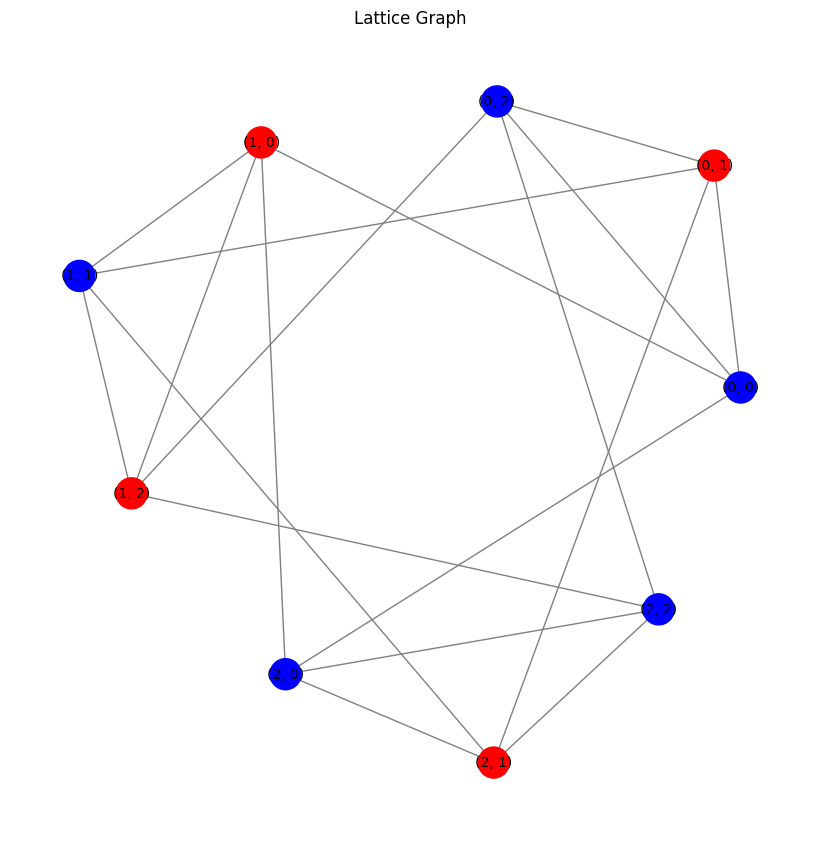

G_pyg: Data(edge_index=[2, 36], x=[9, 3], edge_attr=[36, 3])
G_pyg.x: tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0]])
G_pyg.edge_index: tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5,
         6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8],
        [3, 1, 6, 2, 4, 0, 2, 7, 5, 1, 8, 0, 0, 6, 4, 5, 1, 7, 3, 5, 2, 8, 4, 3,
         3, 7, 0, 8, 4, 6, 8, 1, 5, 7, 2, 6]])
G_pyg.edge_attr: tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 

In [18]:
G, G_pyg = square_9()

**Target State**

In [19]:
torch.set_printoptions(profile = "full")

H = cap_H(G_pyg, J = 1).todense()

eigenvalues, eigenvectors = np.linalg.eigh(H)

print(eigenvalues[:20])

ground_energy = eigenvalues[0]
print(ground_energy)

ground_states = torch.tensor(eigenvectors[:, np.where(eigenvalues - ground_energy < 0.01)[0]]).to(torch.cfloat)

print(ground_states.shape)

print(ground_states)


<ipython-input-13-762255cccfbd>:20: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  H[i,i] = 0.5*J*torch.matmul(torch.matmul(c_i.T, interactions), c_i).item()


[-15.876007   -15.876007   -15.876007   -15.876007   -15.876007
 -15.876007   -15.876007   -15.876007   -14.74456265 -14.74456265
 -14.74456265 -14.74456265 -14.74456265 -14.74456265 -14.74456265
 -14.74456265 -13.24695077 -13.24695077 -13.24695077 -13.24695077]
-15.876006999714084
torch.Size([512, 8])
tensor([[ 0.0000e+00+0.j,  0.0000e+00+0.j,  0.0000e+00+0.j,  0.0000e+00+0.j,
          0.0000e+00+0.j,  0.0000e+00+0.j,  0.0000e+00+0.j,  0.0000e+00+0.j],
        [ 0.0000e+00+0.j,  0.0000e+00+0.j,  0.0000e+00+0.j,  0.0000e+00+0.j,
          0.0000e+00+0.j,  0.0000e+00+0.j,  0.0000e+00+0.j,  0.0000e+00+0.j],
        [ 2.7582e-19+0.j, -1.0539e-17+0.j, -8.6297e-18+0.j,  2.6102e-19+0.j,
          5.1684e-18+0.j,  3.1769e-19+0.j, -3.6712e-18+0.j, -9.1569e-18+0.j],
        [-2.5530e-18+0.j, -3.0939e-17+0.j, -2.7680e-18+0.j,  1.9048e-17+0.j,
          3.2905e-17+0.j,  1.9433e-17+0.j,  5.4846e-18+0.j,  3.1797e-17+0.j],
        [ 2.9000e-18+0.j,  1.3120e-17+0.j,  7.9591e-18+0.j, -1.2246e-17+0.j,

**Model**

In [20]:
gnn_log_amp = GNN(input_dim=3, feature_dim=64, hidden_dim=128, num_core_layers=6)
gnn_pha = GNN(input_dim=3, feature_dim=64, hidden_dim=128, num_core_layers=6, activation = torch.nn.Tanh())

optimizer_log_amp = torch.optim.Adam(gnn_log_amp.parameters(), lr=0.001, weight_decay=1e-5)
optimizer_pha = torch.optim.Adam(gnn_pha.parameters(), lr=0.001, weight_decay=1e-5)


**Optimisation**

In [21]:
#wandb.finish()

In [ ]:
#imaginary time supervised wave optimisation
num_iterations = 26000
gd_steps = 100

H = torch.tensor(H).to(torch.cfloat)

#computational basis
computational_basis = exhaustive(G_pyg)

beta = 0.05

wandb.login()
wandb.init(project="quantum-simulation-fp", name = f"branch_quantum_{datetime.datetime.now().strftime('%Y-%m-%d-%H:%M')}")


for iteration in tqdm(range(num_iterations)):

    #compute the target state
    with torch.no_grad():

        # current quantum state
        psy = torch.zeros((computational_basis.shape[0],2))

        for i in range(computational_basis.shape[0]):
            psy[i,0] = torch.exp(get_output(computational_basis[i,:], G_pyg, gnn_log_amp))
            psy[i,1] = torch.pi * get_output(computational_basis[i,:], G_pyg, gnn_pha)

        # imaginary time evolved state

        #convert psy
        psy_comp = torch.complex(psy[:,0] * torch.cos(psy[:,1]), psy[:,0] * torch.sin(psy[:,1]))
        #init phi
        #phi_comp = psy_comp.clone()

        #i-t evolve
        phi_comp = psy_comp - beta * torch.matmul(H, psy_comp)

        print(f"psy_comp: {psy_comp}")
        print(f"phi_comp: {phi_comp}")



    for gd_step in range(gd_steps):


        #compute current quantum state (the first time is redundant, could flip code, but clarity > negligible speed improvement)
        psy = torch.zeros((computational_basis.shape[0],2))

        for i in range(computational_basis.shape[0]):
            psy[i,0] = torch.exp(get_output(computational_basis[i,:], G_pyg, gnn_log_amp))
            psy[i,1] = get_output(computational_basis[i,:], G_pyg, gnn_pha)

        psy_comp = torch.complex(psy[:,0] * torch.cos(psy[:,1]), psy[:,0] * torch.sin(psy[:,1]))


        #compute overlap with current target
        overlap = compute_overlap(phi_comp, psy_comp)

        #loss
        regularisation_term = torch.log(torch.mean(psy[i,0]))**2
        loss = - torch.special.logit(torch.abs(overlap), eps=1e-6) + 0.0001 * regularisation_term

        #optimise
        # striving for simulataneous optimisation, hoping that this mixing works

        optimizer_pha.zero_grad()
        optimizer_log_amp.zero_grad()

        loss.backward()

        optimizer_pha.step()
        optimizer_log_amp.step()

        #logging
        print(f"iteration: {iteration} -- overlap: ", torch.abs(overlap).item())

        with torch.no_grad():
            excess_energy = (psy_comp.conj() @ H @ psy_comp) / (psy_comp.conj() @ psy_comp)
            excess_energy = excess_energy.to(torch.float) - ground_energy

        #compute the best overlap with ground states and log it
        with torch.no_grad():
            best_overlap = torch.tensor(0)
            for i in range(ground_states.shape[1]):
                current_overlap = compute_overlap(ground_states[:,i], psy_comp)
                best_overlap = torch.max(torch.abs(current_overlap), best_overlap)

        wandb.log({"best_overlap_with_ground": float(torch.abs(best_overlap).item()),
                   "psy_phi_overlap": torch.abs(overlap).item(),
                   "excess_energy": excess_energy.item()})


        if torch.abs(overlap).item() > 0.95:
            break

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dan_mon_uni (dan_mon_uni-uni). Use `wandb login --relogin` to force relogin


  0%|          | 0/26000 [00:00<?, ?it/s]

psy_comp: tensor([3.5085+4.9914j, 3.5024+4.9906j, 3.4998+4.9902j, 3.4934+4.9889j,
        3.5024+4.9906j, 3.4962+4.9894j, 3.4934+4.9889j, 3.4869+4.9873j,
        3.4998+4.9902j, 3.4934+4.9889j, 3.4911+4.9890j, 3.4844+4.9872j,
        3.4937+4.9894j, 3.4872+4.9877j, 3.4847+4.9877j, 3.4779+4.9856j,
        3.5028+4.9911j, 3.4967+4.9903j, 3.4938+4.9894j, 3.4874+4.9881j,
        3.4967+4.9903j, 3.4905+4.9891j, 3.4874+4.9881j, 3.4809+4.9865j,
        3.4938+4.9894j, 3.4874+4.9881j, 3.4848+4.9877j, 3.4781+4.9859j,
        3.4877+4.9886j, 3.4812+4.9869j, 3.4784+4.9864j, 3.4716+4.9843j,
        3.4998+4.9902j, 3.4937+4.9894j, 3.4911+4.9890j, 3.4847+4.9877j,
        3.4934+4.9889j, 3.4872+4.9877j, 3.4844+4.9872j, 3.4779+4.9856j,
        3.4904+4.9886j, 3.4840+4.9873j, 3.4817+4.9874j, 3.4750+4.9856j,
        3.4840+4.9873j, 3.4775+4.9856j, 3.4750+4.9856j, 3.4682+4.9835j,
        3.4938+4.9894j, 3.4877+4.9886j, 3.4848+4.9877j, 3.4784+4.9864j,
        3.4874+4.9881j, 3.4812+4.9869j, 3.4781+4.9859j

<ipython-input-22-f727a27775f6>:79: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:308.)
  excess_energy = excess_energy.to(torch.float) - ground_energy


psy_comp: tensor([3.5940+0.4963j, 3.5829+0.5024j, 3.5586+0.5385j, 3.5470+0.5445j,
        3.5829+0.5024j, 3.5714+0.5083j, 3.5470+0.5445j, 3.5350+0.5502j,
        3.5586+0.5385j, 3.5470+0.5445j, 3.5228+0.5799j, 3.5108+0.5857j,
        3.5474+0.5444j, 3.5355+0.5502j, 3.5113+0.5857j, 3.4989+0.5912j,
        3.5831+0.5019j, 3.5720+0.5080j, 3.5472+0.5440j, 3.5356+0.5499j,
        3.5720+0.5080j, 3.5605+0.5138j, 3.5356+0.5499j, 3.5236+0.5556j,
        3.5472+0.5440j, 3.5356+0.5499j, 3.5110+0.5853j, 3.4989+0.5910j,
        3.5361+0.5499j, 3.5241+0.5556j, 3.4994+0.5910j, 3.4870+0.5965j,
        3.5586+0.5385j, 3.5474+0.5444j, 3.5228+0.5799j, 3.5113+0.5857j,
        3.5470+0.5445j, 3.5355+0.5502j, 3.5108+0.5857j, 3.4989+0.5912j,
        3.5224+0.5802j, 3.5108+0.5860j, 3.4864+0.6208j, 3.4744+0.6264j,
        3.5108+0.5860j, 3.4989+0.5915j, 3.4744+0.6264j, 3.4620+0.6317j,
        3.5472+0.5440j, 3.5361+0.5499j, 3.5110+0.5853j, 3.4994+0.5910j,
        3.5356+0.5499j, 3.5241+0.5556j, 3.4989+0.5910j

## **2.4** - merge
- quantum superposition
- mcmc